# Exploring _"Disinformation"_ at `EUvsDisinfo`


> Disinformation is the creation, presentation and dissemination of verifiably
false or misleading information for the purposes of economic gain or
intentionally deceiving the public.
> (...)
>  Under the [European] Commission’s definition, disinformation does not
include misleading advertising, reporting errors, satire and parody, or clearly identified partisan news and commentary.<br />
> _[EU Action Plan Against Disinformation](https://www.eca.europa.eu/lists/ecadocuments/ap20_04/ap_disinformation_en.pdf)_, 2018

The notion of `disinformation` is used increasingly frequently. There are different ways of gaining a better understanding of this notion. Examples are looking up its definition in a dictionary or finding some text introducing the concept.

Here we will investigate the *use* of the word `disinformation`. We do this on the basis of a dataset from the `EUvsDisinfo`, a website produced by the East StratCom Task Force of the European Union.

After a start in late 2015, EUvsDisinfo now contains almost a thousand news articles and a database with more than thirteen thousand "disinformation cases". More than any other producer, it is therefor indicative of how the words `disinformation` is used in practice.

## Table of Contents

* [Methodology](#methodology)
* [Tokenization](#tokenization)
* [Exploration](#exploration)
    * [Wordcloud](#exploration_wordcloud)
    * [Word sequences](#exploration_word_sequences)
* [Narratives](#narratives)
    * [Frequencies: TF/IDF](#frequencies)
    * [Clustering](#clustering)
        * [Describing narratives: Summarizing clusters](#summarization)
        * [2D projection of clusters using Word vectors and PCA](#2d_projection)
        * [Similarities between clusters](#cluster_similarities)
* [Where from here?](#wherefromhere)
* [Conclusion](#conclusion)


<a id='methodology'></a>
## Methodology

As we try to understand the usage of `disinformation` we focus on the word "disinformation". Here we extract all sentences from the larger dataset of EUvsDisinfo news articles and database cases that contain the word `disinformation`.

This will not give us a complete representation of all that is relevant around `disinformation` - sentences in context will also contain relevant data - but we can assume on the basis of proximity that the most relevant data is in the sentences containing the word.

The character of the followed methodology is one of exploration. That means that instead of following a pre-defined approach, we will go from one step to the next to gain a better understanding of the data. We will restrict ourselves here primarily but not exclusively to use of statistical methods.


## Dataset

This dataset consists of more than 13,000 "disinformation cases" and over 900 news articles, all produced since 2015.

Of the 14,550 texts in the original dataset, 8462 contained the word `disinformation`. The word `disinformation` in the original data being present in less than 60% of the texts, shows that focus on the word `disinformation` will miss a significant part of the data.


Read 14550 items from database.
8462 contained the word 'disinformation'.
242 contained link (removed from dataset).
Total occurrences: 13190
Read 14550 items from database.
7493 contained the word 'narrative'.
21 contained link (removed from dataset).
Total occurrences: 9415

### Data format

We will use two formats of CSVs:

1. CSV containing sentences with terms:

|sentence|url|date_published|type|
|---|---|---|---|


2. CSV containing overview of *all* original content (news and `cases`):

|date_published|type|
|---|---|



<a id='tokenization'></a>
# Tokenization

Our statistical analysis above depends on splitting sentences into sets of tokens. Note that a statistical analysis is based on counting words and ignores the order of words in sentences.

In the course of this notebook we will extend the information of tokenization to meta-data for tokens, that is, beyond mere tokenization into a set of strings. For terminology we will still call the whole of processing steps `tokenization`.

## What do we want from a tokenizer?

Basic tokenization consists of splitting sentences into sets of tokens. A basic function uses spaces and interpunction to determine where to split a string making up a sentence and turn it into a list of tokens.

* Identify individual tokens
* Remove stopwords
* Identify entities
* Normalize entities (so there are no duplicate entries in the statistiscs
* Combine compound terms, e.g. `conspiracy theory`
* Get a vector representation for terms to determine similarity
* Get part-of-sentence representation for a word

### Replacing standards tokenizers

Below we will use two applications for analysing our dataset:
* [Wordcloud](https://amueller.github.io/word_cloud/index.html)
* [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Each of them includes its own tokenizer, which allows for a number of configuration options. These tokenizers would bring us much of the way we will be going in this notebook, but not all the way. For that reason, we will start from the start use a custom tokenizer built as a wrapper around [spaCy](https://spacy.io).



# Importing python libraries

Below we will import all libraries used in the course of the notebook. A good number of them will be used only way deeper in the notebook and we will not explain their role right here.

In [1]:
import pandas as pd
import numpy as np
import regex as re
import traceback
import math
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from wordcloud import WordCloud
import spacy
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import sqlite3
import csv

In [2]:
from spacy.tokenizer import Tokenizer
from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER, CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS
from spacy.util import compile_infix_regex
from spacy.matcher import DependencyMatcher

In [3]:
# Configuration
SKIP_WORDCLOUDS = False

In [4]:
# Define ANSI colors
#  - to write ANSI colors to the output we do [START OF MARKUP]string[ENDC],
#  e.g. print(f'A sentence on {bclors.DISINFO}disinformation{bcolors.ENDC}.')
#
class bcolors:
    DISINFO = '\033[95m'
    VERB = '\033[94m'
    TOPIC = '\033[96m'
    CORTINA = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Exploring the dataset

## All publications



In [5]:
pubs_df = pd.read_csv('allpubs.csv')
pubs_df['year'] = pubs_df['date_published'].str[:4]
pubs_df['year'].astype(np.int32)
pubs_df.drop(columns=['date_published'], inplace=True)

pubs_df = pd.get_dummies(pubs_df, columns=['type'])
pubs_df['year'].astype(np.int32)

sum_df = pubs_df.groupby(['year']).agg({'type_claim': 'sum', 'type_news': 'sum'}).reset_index()
sum_df['type_claim'] = sum_df['type_claim'].astype(np.int32)
sum_df.columns = ['year', 'cases', 'news']
sum_df

,year,cases,news
0,2015,341,0
1,2016,1923,86
2,2017,1284,160
3,2018,992,144
4,2019,2647,189
5,2020,3499,183
6,2021,2851,166
7,2022,85,0


In [6]:
print("Total cases: ", sum_df['cases'].sum())
print("Total News articles: ", sum_df['news'].sum())

Total cases:  13622
Total News articles:  928


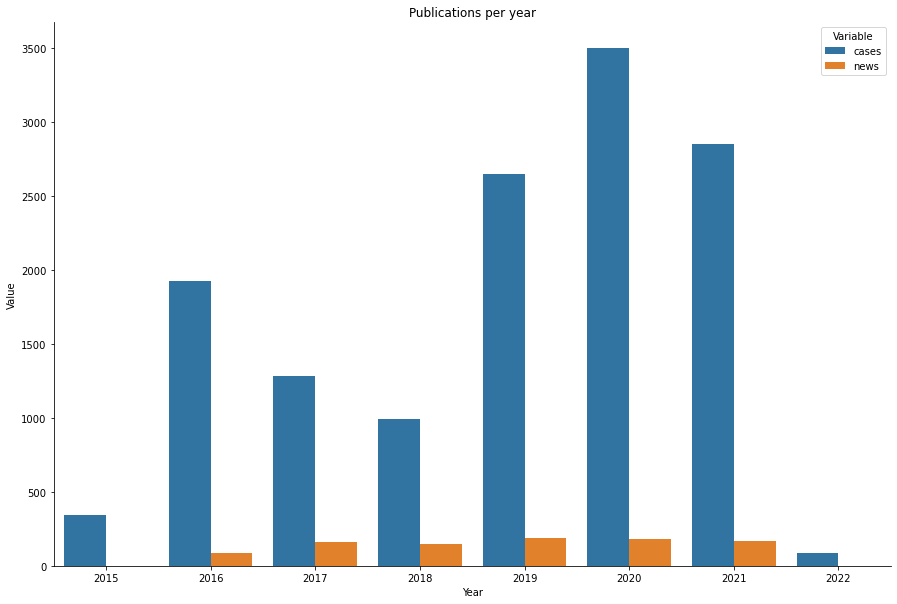

In [7]:
fig, ax1 = plt.subplots(figsize=(15, 10))
ax1.set_title("Publications per year")
tidy = sum_df.melt(id_vars='year').rename(columns=str.title)
sns.barplot(x='Year', y='Value', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)

Year over year, we see a relatively stable set of news articles, circa 150-200, and a fluctuating number of `disinformation cases`.
up to several thousand per year.

### NLP pipeline: spaCy

Our dataset consists of sentences, but to make a statistical analysis we need to parse them into words or multi-word terms. There are different ways to do this and much of this notebook will be about creating different tokenizers.

We define a standard spaCy pipeline based on a large model (we need that later when we need vectors) and add a custom tokenizer to it to be able to deal with the frequently used term `pro-Kremlin`.

In [8]:
nlp = spacy.load('en_core_web_lg')

In [9]:
def custom_tokenizer(nlp):
    """Tokenize words with hyphens as single terms, rather than two terms.
    This is done here specifically to deal with `pro-Kremlin`.
    """
    infixes = (
        LIST_ELLIPSES
        + LIST_ICONS
        + [
            r"(?<=[0-9])[+\-\*^](?=[0-9-])",
            r"(?<=[{al}{q}])\.(?=[{au}{q}])".format(
                al=ALPHA_LOWER, au=ALPHA_UPPER, q=CONCAT_QUOTES
            ),
            r"(?<=[{a}]),(?=[{a}])".format(a=ALPHA),
            #r"(?<=[{a}])(?:{h})(?=[{a}])".format(a=ALPHA, h=HYPHENS),
            r"(?<=[{a}0-9])[:<>=/](?=[{a}])".format(a=ALPHA),
        ]
    )

    infix_re = compile_infix_regex(infixes)

    return Tokenizer(nlp.vocab, prefix_search=nlp.tokenizer.prefix_search,
                                suffix_search=nlp.tokenizer.suffix_search,
                                infix_finditer=infix_re.finditer,
                                token_match=nlp.tokenizer.token_match,
                                rules=nlp.Defaults.tokenizer_exceptions)



In [10]:
class SimpleTokenizer(object):
    """Wrapper around the spaCy pipeline for tokenization.
    - split sentence into tokens
    - use custom tokenizer to *not* break words separated by a dash,
      most importantly for the ubiquitous word "pro-Kremlin" in our dataset
    - preserve `US` (=United States) as a token
    - reduce tokens to their lemma"""
    def __init__(self, spacy_tokenizer):
        self.spacy_tokenizer = spacy_tokenizer
        self.spacy_tokenizer.tokenizer = custom_tokenizer(self.spacy_tokenizer)
    
    
    def __call__(self, sentence, **kw):
        """Convert a sentence into a list of combinations of tokens with their meta-data"""
        sentences = sentence.split('\n')
        lst = []
        for s in sentences:
            doc = self.spacy_tokenizer(s)
            for token in doc:
                # ignore stopwords and interpunction
                # don't let 'US' be removed due to 'us' being a stopword
                if token.text == 'US' or (not token.is_stop and not token.is_punct):
                    word = token.lemma_
                    if token.text == 'US':
                        word = 'US'
                    lst.append(word)

        return lst

In [11]:
my_tokenizer = SimpleTokenizer(nlp)

<a id='exploration'></a>
# Exploration

Exploring the dataset.

<a id='exploration_wordcloud'></a>
## Wordcloud

We take all sentences in our dataset and create a wordcloud from them which displays the prevalance of terms.

We make two extra steps:
1. Define `pro-Kremlin` as a term, to prevent it from being split up in `pro` and `Kremlin`
2. Reduce all words to their `lemma`, to prevent singular and plural versions from being seen as separate terms
3. Exclude `US` from this process to prevent it from being reduced to `us` (as in `us` and `them`) and then be excluded as a stop word.

In [12]:
# Deal with "pro-Kremlin": we don't want to split it up in "pro" and "Kremlin"
# and pass a regexp other than the default r"\w[\w']+" to WordCloud
# Note that (?: ... ) serves to prevent groups being returned for this parenthesized pair.
token_pattern_with_prokremlin = r"(?:[pP]ro-[kK]remlin)|(?:\w[\w']+)"

def normalize_text(lst):
    normalized_text = []
    for sentence in lst:
        # Use spaCy to parse each sentence into tokens
        doc = nlp(sentence)
        for tok in doc:
            # Don't let 'US' for 'United States' be removed as the stopword 'us' ("and them")
            if tok.text == 'US':
                normalized_text.append(tok.text)
            else:
                normalized_text.append(tok.lemma_)
    
    text = ' '.join(normalized_text)
    return text

In [13]:
def make_frequencies(lst, tokenizer):
    """Create dictionary with occurences for tokens.
    :param lst: list of sentences
    :return: dictionary of tokens to frequencies."""
    d = Counter()
    for sentence in lst:
        try:
            for t in tokenizer(sentence):
                d[t] += 1
        except:
            print(f"make frequencies({sentence} failed", tokenizer(sentence))
    return dict(d)

In [14]:
def make_wordcloud(lst, from_frequencies=False, tokenizer=None, max_words=100):
    """Create a word cloud.
    :param lst: list of sentences"""
    if SKIP_WORDCLOUDS:
        return "Skipping creation of WordCloud as SKIP_WORDCLOUDS=True"
    
    wc = WordCloud(collocations = False, max_words=max_words, background_color = 'white', regexp=token_pattern_with_prokremlin, width=800, height=400)
    if not from_frequencies:
        text = normalize_text(lst)
        word_cloud_diagram = wc.generate(text)
    else:
        freqs = make_frequencies(lst, tokenizer)
        word_cloud_diagram = wc.generate_from_frequencies(freqs)
    plt.figure(figsize=(15,20))
    plt.imshow(word_cloud_diagram, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [15]:
disinformation_df = pd.read_csv('disinformation.csv')

In [16]:
disinformation_df.shape

(13190, 4)

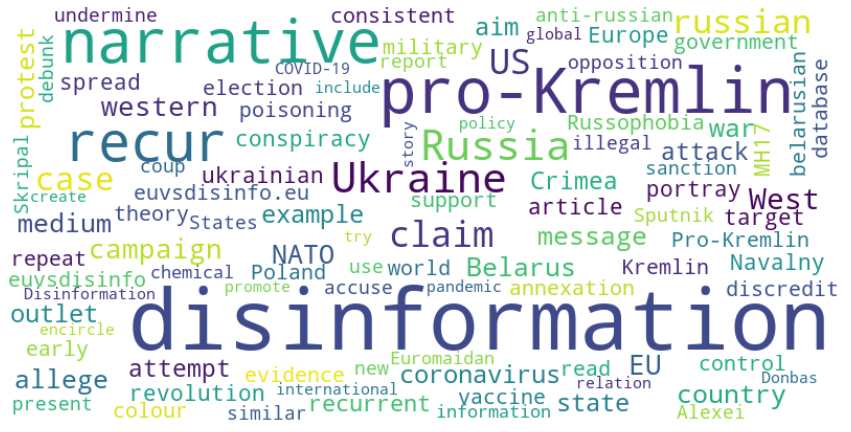

In [17]:
make_wordcloud(
    disinformation_df['sentence'].to_list(), 
    from_frequencies=True,
    tokenizer=my_tokenizer
)

Obviously, given that our dataset consists of sentences containing the word `disinformation`, that word is prevalent.

Other dominant terms are `pro-Kremlin`, `narrative`, `Russia`, `recur` (lemma of `recurring`), and `NATO`.

### TF/IDF

We can analyse the prevalence of terms in our dataset by the metric of `Term Frequency / Inverse Document Frequency`.

A higher number indicates a better result.

In [18]:
def plot_toplist_df(df, max_items=10):
    """Create horizontal barchart from dataframe with 'word' and 'freq'"""
    toplist = df.head(max_items)
    plt.figure(figsize=(14,8))
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(data=toplist, y='word', x='freq', orient='h', color=sns.color_palette()[0])

In [19]:
text = normalize_text(disinformation_df['sentence'].to_list())
# We set `lowercase=False` to prevent further normalization to lowercase, as that would
# let us lose the word `US`.
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1), lowercase=False, token_pattern=token_pattern_with_prokremlin)
vectors = vectorizer.fit_transform([text])
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()
tfidf_df = pd.DataFrame(denselist, columns=feature_names).T.reset_index()
tfidf_df.columns = ['word', 'freq']
tfidf_df = tfidf_df.sort_values(by='freq', ascending=False)

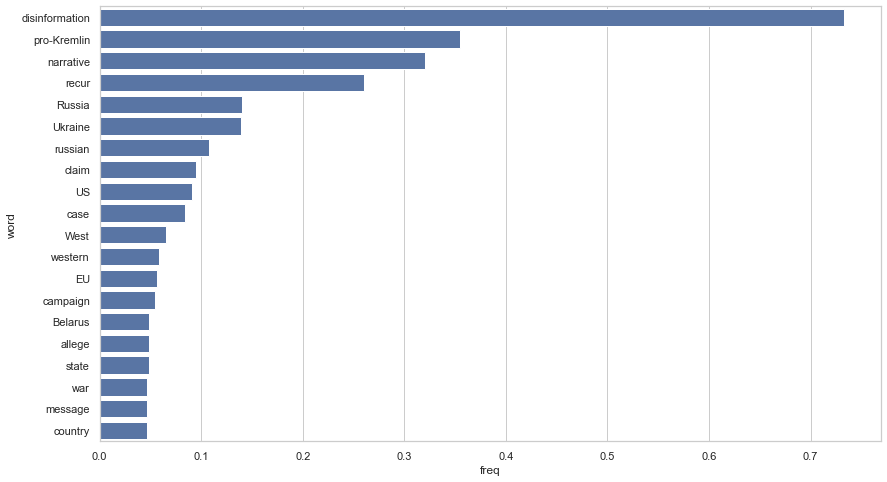

In [20]:
plot_toplist_df(tfidf_df, max_items=20)

## Observations

What we see here:
* Central is the word `disinformation`. That should be no surprise, as our dataset contains of sentences that all contain this word.
* Next biggest is the word `pro-Kremlin`. Against no surprise, given that the dataset is based on a six year project of "revealing pro-Kremlin disinformation".
* Slightly smaller we find `recur` (lemma of `recurring`) and `narrative`.
* `Ukraine`, `Russia`, `Russian`
* `claim`, `US`, and `case`
* Note that two duplicate-like notions were allowed to co-exist: Russia and Russian, West and western. 

<a id='exploration_word_sequences'></a>
## Word sequences

In the above diagram individual words are considered, with the exception of `pro-Kremlin`.
But what would it look like if we consider pairs of words? Using the standard tokenizer of Wordcloud, we can do this by setting the `collocations` parameter to `WordCloud` to the value `True`. This will lead to statistics over a set of tokens consisting not only of single words, but also of bigrams, that is, concatenations of two words.

In [21]:
class NgramTokenizer(SimpleTokenizer):
    """Wrapper around the spaCy pipeline for tokenization.
    Tokenize into n-grams with n > 1.
    """
    def __init__(self, spacy_tokenizer):
        super().__init__(spacy_tokenizer)    
    
    def __call__(self, sentence, **kw):
        """Convert a sentence into a list of combinations of tokens with their meta-data"""
        sentences = sentence.split('\n')
        lst = []
        for s in sentences:
            doc = self.spacy_tokenizer(s)
            # Add noun chunks of more than one words, but remove stopwords from them
            for chunk in doc.noun_chunks:
                ch = [t.lemma_ for t in chunk if not t.is_stop and not t.is_punct]
                if len(ch) > 1:
                    lst.append(' '.join(ch))

        return lst

In [22]:
my_tokenizer = NgramTokenizer(nlp)

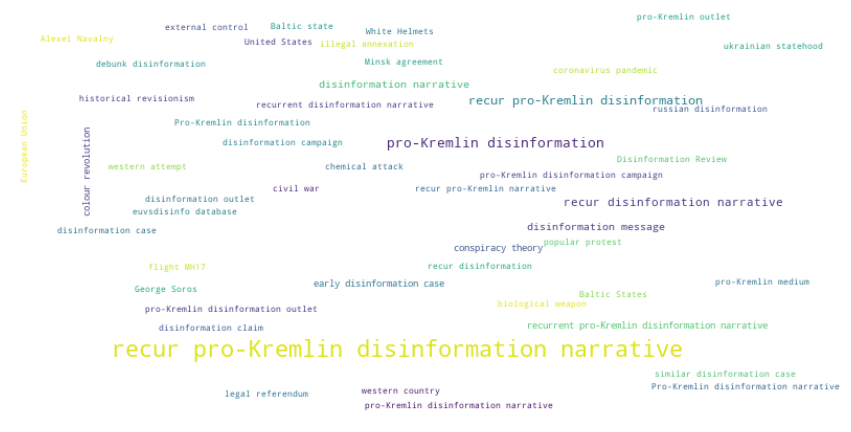

In [23]:
make_wordcloud(
    disinformation_df['sentence'].to_list(), 
    from_frequencies=True,
    tokenizer=my_tokenizer,
    max_words=50
)

In [24]:
d = make_frequencies(disinformation_df['sentence'].to_list(), my_tokenizer)
words = []
freqs = []
for k,v in d.items():
        words.append(k)
        freqs.append(v)
freq_df = pd.DataFrame({'word': words, 'freq': freqs})

In [25]:
fdf = freq_df.sort_values(by='freq', ascending=False)
fdf.head(15)

,word,freq
16,recur pro-Kremlin disinformation narrative,3146
13,pro-Kremlin disinformation,616
698,recur pro-Kremlin disinformation,560
113,recur disinformation narrative,502
58,disinformation message,371
64,disinformation narrative,370
116,conspiracy theory,324
266,recurrent pro-Kremlin disinformation narrative,319
1344,early disinformation case,302
268,colour revolution,295


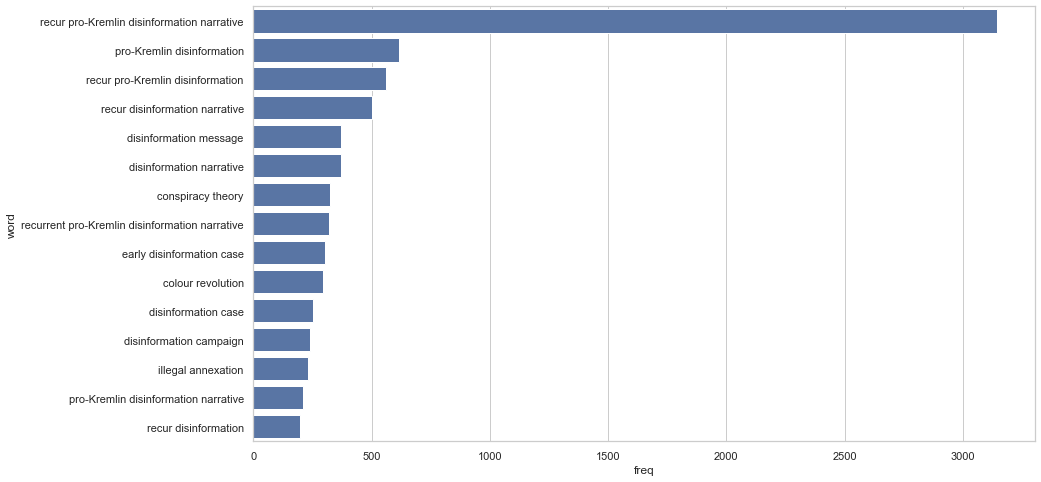

In [26]:
plot_toplist_df(fdf, max_items=15)

The phrase `recur(ring) pro-Kremlin disinformation narrative` stands out: we find it being used over three thousand times in a dataset of a little over fourteen thousand sentences. That is, it occurs in about one of four sentences in our dataset.

We see a number of other terms in combination with disinformation:
* message
* case
* campaign

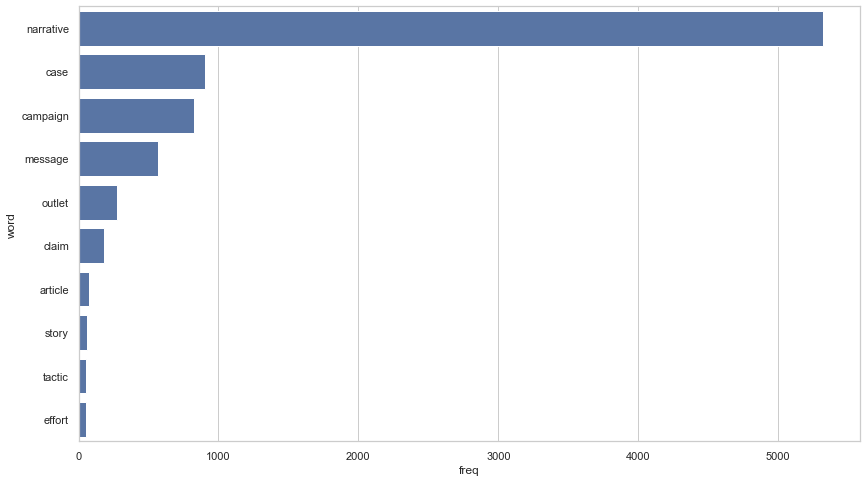

In [27]:
fdf_disinfo_x = fdf[ fdf['word'].str.match('.*disinformation \w+') ]
fdf_disinfo_x = fdf_disinfo_x.replace(to_replace=r'.*disinformation (\w+)', value=r'\1', regex=True)
fdf_disinfo_x = fdf_disinfo_x.groupby('word').sum().sort_values(by='freq', ascending=False).reset_index()
plot_toplist_df(fdf_disinfo_x, max_items=10)

We also see a number of phrases without the term `disinformation`:
* conspiracy theory
* colour revolution
* illegal annexation

Let's see if there are more terms without the term `disinformation`.

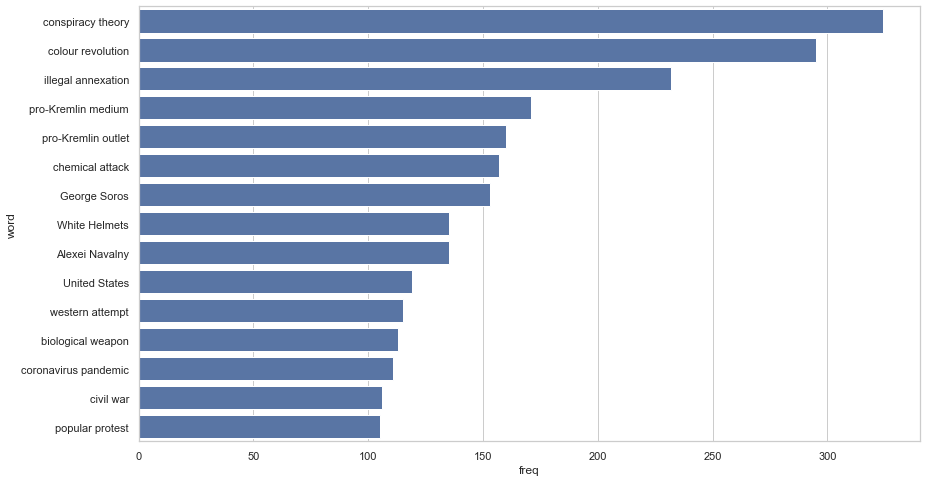

In [28]:
plot_toplist_df(fdf[ fdf['word'].str.find('disinformation') == -1 ], max_items=15)

## Analysis of the results

In the diagram above we see multiple bigrams.

Let's look at some:
- `pro-Kremlin disinformation`, `pro-Kremlin disinformation`, `disinformation case`, `disinformation campaign`.
- `Alexei Navalny`, `White Helmets`, `Baltic State`, `flight MH17`
- `illegal annexation`, `colour revolution`, `chemical attack`

To create an ranking according to the TF/IDF metric we use `TfidfVectorizer`. This has a parameter `ngram_range`, which sets a minimum and maximum for the ngrams used to tokenize the text for applying the metric. By default this is set to `(1,1)`, meaning tokenization only into single words.

We can set is to include bigrams by setting (1,2) and including trigrams by setting (1,3). If we are interested only in bigrams or trigrams we can raise the minimum, e.g. (3,3) for trigrams only.

<a id='narratives'></a>
# Narratives

In the EU definition of `disinformation` we don't find the word `narrative` and neither does `narrative` occur in the leading document ["EU Action Plan Against Disinformation"](https://www.eca.europa.eu/lists/ecadocuments/ap20_04/ap_disinformation_en.pdf)

Given the prevalence of the word `narrative` in the actual usage of the term `disinformation` as we found studying our dataset, this is puzzling.

Let's see the Oxford Languages definition:

> _`narrative` ~ a spoken or written account of connected events; a story._

Compare this with the European Union's definition of `disinformation` which we saw above:

> _`Disinformation` ~ the creation, presentation and dissemination of verifiably false or misleading information for the purposes of economic gain or intentionally deceiving the public._

What counts here is that `information` can be about anything, but in practice we find it narrowed down to events. And events are typically determined by people, locations, and actions.

For our current exploration, this means that we have reason to narrow down our data in a different way than a purely statistical on word occurrences. Specifically, named entities are taking a central place as they are central in `narratives`.













In [29]:
narrative_df = pd.read_csv('narrative.csv')
narrative_sentences = narrative_df['sentence'].to_list()

<a id='frequencies'></a>
# Frequencies: TF/IDF

https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.YhMevZNBy-g

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


In [31]:
def create_tfidf(text, ngram_range=(1,3), output='dataframe', tokenizer=None):
    # Now we set an ngram_range to a minumum of 1 and maximum of three. That means that ngrams
    # will be counted like individual tokens.
    # We set `lowercase=False` to prevent further normalization to lowercase, as that would
    # let us lose the word `US` because 'us' is a stop word.
    if tokenizer:
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, tokenizer=tokenizer, lowercase=False)
    else:
        vectorizer = TfidfVectorizer(stop_words='english', ngram_range=ngram_range, lowercase=False, 
                             token_pattern=token_pattern_with_prokremlin)
    if type(text) == list:
        text = '\n'.join(text)
    elif len(text) < 120:
        quicktok = tokenizer(text)
        if len(quicktok) == 0:
            # either empty input or all words filtered out by tokenizer
            if output == 'dict':
                return {}
            else:
                return pd.DataFrame([], columns=['word','freq'])
        
    vectors = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    dense = vectors.todense()
    denselist = dense.tolist()
    if output == 'dataframe':
        if denselist:
            tfidf_df = pd.DataFrame(denselist, columns=feature_names).T.reset_index()
            tfidf_df.columns = ['word', 'freq']
            tfidf_df = tfidf_df.sort_values(by='freq', ascending=False)
        else:
            tfidf_df = pd.DataFrame([], columns=['word','freq'])
        return tfidf_df
    elif output == 'dict':
        d = {}
        for i in range(len(feature_names)):
            d[feature_names[i]] = denselist[0][i]
        return d
    else:
        return None

## Extending the tokenizer for compound terms

If specific bi-grams are more prevalent than unigrams, they might be of extra relevance.
We therefore want to be able to treat them as a single term.

**Example:**
> 'car' and 'park' becomes 'car park'

In [32]:
# Treat the following as single terms
compound_list = [
        'conspiracy theory',
        "coup d'état",
        'illegal annexation',
        'chemical attack',
        "colour revolution"
]

In [33]:
# These words are like "stopwords": they add no extra meaning to any sentence or group of sentences in our dataset
remove_list = [
    'disinformation',
    'narrative',
    'recur',
    'recurrent',
    'pro-Kremlin',
    'bit.ly*' # this doesn't deal with the path of the URL; statistics will make that disappear
]

In [34]:
# Normalise entities to one form
entities = {
    'the united states of america': 'US',
    'the united states': 'US',
    'united states': 'US',
    'the european union': 'EU',
    'european union': 'EU',
    'flight mh17': 'MH17',
    'JIT': 'Joint Investigation Team',
    'International Joint Investigation': 'Joint Investigation Team'
}

In [35]:
from spacy.pipeline import EntityRuler 
 
pattern_navalny = {"label": "PERSON", "pattern": [
    {"LOWER": "alexei", "OP": "?"},
    {"LOWER": "navalny"}]}
pattern_skripal = {"label": "PERSON", "pattern": [
    {"LOWER": "sergei", "OP": "?"},
    {"LOWER": "skripal"}]}
pattern_litvinenko = {"label": "PERSON", "pattern": [
    {"LOWER": "alexander", "OP": "?"},
    {"LOWER": "litvinenko"}
    ]}
pattern_putin = {"label": "PERSON", "pattern": [
    {"LOWER": "vladimir", "OP": "?"},
    {"LOWER": "putin"}]}
pattern_west = {"label": "NORP", "pattern": [
    {"TEXT": "West"}
    ]}
pattern_sputnik = {"label": "PRODUCT", "pattern": [
    {"LOWER": "sputnik"}, 
    {"LOWER": "v"}]}
pattern_covid19 = {"label": "PRODUCT", "pattern": [
    {"LOWER": "covid-19"}]}  # Note that are customized tokenizer doesn't split on '-'


patterns = [
    pattern_navalny, pattern_skripal, pattern_putin, pattern_litvinenko, pattern_west,
    pattern_sputnik, pattern_covid19
]

nlp = spacy.load('en_core_web_lg')
nlp.tokenizer = custom_tokenizer(nlp)

ruler = nlp.add_pipe("entity_ruler","extra_entities", after='ner', config={"overwrite_ents": True})
ruler.add_patterns(patterns)

nlp.add_pipe('merge_entities')

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [36]:
class DisinfoTokenizer(SimpleTokenizer):
    def __init__(self, spacy_tokenizer, with_vectors=False, with_meta=False, 
                 compounds=[], remove=[], entities={}, lastname_only=True):
        super().__init__(spacy_tokenizer)
        self.with_vectors = with_vectors
        self.with_meta = with_meta
        self.compounds = compounds
        self.remove= remove
        self.entities = entities
        self.lastname_only = lastname_only
    
    def _normalize_entities(self, entity, ent_type):
        """Normalize entities in the domain
        :param entity: string representing an entity
        :return: normalized version of entity"""
        #print('normalize(',entity,',',ent_type,')')
        if ent_type == 'PERSON':
            # For PERSONs we only look at the last name
            if self.lastname_only:
                lst = entity.split(' ')
                return lst[-1]
            else:
                return entity
        else:       
            if entity.lower() in self.entities.keys():
                return self.entities[entity.lower()]
            else:
                if entity.startswith('the '):
                    entity = entity[4:]
                return entity

    def _merge_compounds(self, lst):
        """Merge tokens into a compound term, e.g. 'car' and 'park' into 'car park'"""
        if len(lst) < 2:
            return lst
        else:
            term = f'{lst[-2][0]} {lst[-1][0]}'
            if term in self.compounds:
                vector = None
                if 'vector' in lst[-1][1].keys():
                    vector = lst[-1][1]['vector']
                # assume that all compound terms are nouns
                meta = {
                    'ent_type': None,
                    'pos': 'NOUN'
                }
                if self.with_vectors:
                    meta['vector'] = vector
                lst = lst[:-2] + [(term, meta)]
            return lst
    
    def __call__(self, sentence, **kw):
        """Convert a sentence into a list of combinations of tokens with their meta-data"""
        sentences = sentence.split('\n')
        lst = []
        origdict = {}
        for k, v in kw.items():
            origdict[k] = self.__dict__[k]
            self.__dict__[k] = v
            
        for s in sentences:
            doc = self.spacy_tokenizer(s)
            for token in doc:
                # ignore stopwords and interpunction
                # don't let 'US' be removed due to 'us' being a stopword
                if token.text == 'US' or (not token.is_stop and not token.is_punct):
                    meta = {}
                    is_entity = False
                    if token.ent_type_ != '':
                        for e in doc.ents:
                            if e.end - e.start == 1 and token.i == e.start:
                                word = self._normalize_entities(e.text, token.ent_type_)
                                meta['ent_type'] = token.ent_type_
                                is_entity = True                                
                                break
                                
                    if not is_entity:
                        word = token.lemma_
                        meta['ent_type'] = None
                        
                    meta['pos'] = token.pos_
                    
                    if self.with_vectors:
                        meta['vector'] = token.vector
                    
                    lst.append((word, meta))
                        
                    # Check if we just created a compound
                    if self.compounds:
                        lst = self._merge_compounds(lst)
                        
                    # To remove compound terms, any removal is done after addition is completed
                    if len(lst) > 0:
                        if lst[-1][0] in self.remove:
                            lst.pop()
                        else:
                            for p in self.remove:
                                if p.find('*') > -1:
                                    p = p.replace('*', '')
                                    if lst[-1][0].find(p) > -1:
                                        lst.pop()
                            

        if not self.with_meta:
            lst = [x[0] for x in lst]
                        
        for k, v in origdict.items():
            self.__dict__[k] = v

        return lst

In [37]:
# Reset our tokenizer
#my_tokenizer = SimpleTokenizer(nlp)
my_tokenizer = DisinfoTokenizer(nlp, compounds=compound_list, remove=remove_list, entities=entities)
cv=CountVectorizer(tokenizer=my_tokenizer) 
word_count_vector=cv.fit_transform(disinformation_df['sentence'].to_list())

In [38]:
cv.get_feature_names_out()[:10]

array([' ', '  ', '"arab spring', '"syrian war"', '$', '+', '-a',
       '-about', '-especially', '-such'], dtype=object)

In [39]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)


TfidfTransformer()

In [40]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_weights"]) 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])
df_idf.tail()

,idf_weights
“nord stream 2,9.794143
“normandy,9.794143
“panama papers,9.794143
“war,9.794143
€110 million,9.794143


In [41]:
# count matrix 
count_vector=cv.transform(disinformation_df['sentence'].to_list()) 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [42]:
first_document_vector = tf_idf_vector[1]
tfidf_df = pd.DataFrame(first_document_vector.T.todense(), index=cv.get_feature_names_out(), columns=["tfidf"]) 
tfidf_df.sort_values(by=["tfidf"],ascending=False)
tfidf_df.tail()

,tfidf
“nord stream 2,0.0
“normandy,0.0
“panama papers,0.0
“war,0.0
€110 million,0.0


In [43]:
from sklearn.cluster import KMeans
from sklearn import metrics

NUMBER_OF_CLUSTERS = 16
CENTROIDS = 20
MAX_ITER = 12

def analyse_cluster_distribution(X, min_k, max_k, cat=None):
    """Plot SSE for different number of clusters."""

    sse = []
    cluster_counts = []
    list_k = list(range(min_k, max_k+1))
    for k in list_k:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=MAX_ITER, n_init=1, random_state=0)
        kmeans.fit(X)
        cluster_counts.append(pd.Series(kmeans.labels_).value_counts())
        sse.append(kmeans.inertia_)
        
    title = 'Sum of squared distance for chosen number of clusters'
    if cat is not None:
        title += f" for '{cat}'"
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o')
    plt.xlabel(r'Number of clusters')
    plt.ylabel('Sum of squared distance');
    plt.title(title)
    plt.show()
    
    return cluster_counts

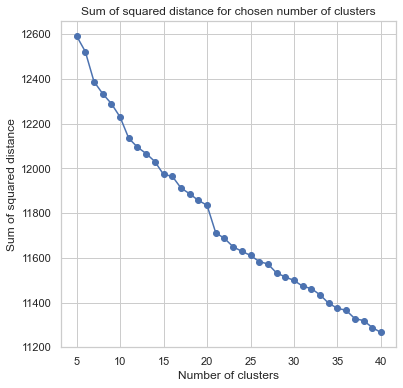

In [44]:
cluster_counts = analyse_cluster_distribution(tf_idf_vector, min_k=5, max_k=40)


We would like to apply the ["Elbow method"](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to this diagram, which tells that the optimal number of clusters can be derived from identifying the point in the diagram where the downward slope has an angle like an elbow from going down steeply to going down at a slower pace.

Just looking at the picture, no real "elbow" is visible: the slope remains mostly constant. Partly, we can ascribe this to a normal development: more clusters are more fine-grained. Partly, we can ascribe the lack of a reducing slope to overfitting.

# What are we to make of this?

Most saliently, we notice n-grams:
* pro-Kremlin disinformation
* disinformation narrative
* pro-Kremlin disinformation narrative
* recur(rent) pro-Kremlin disinformation

### pro-Kremlin

EUvsDisinformation set itself the goal of "revealing pro-Kremlin disinformation", but there are two questions:
- How does 'pro'something agency relate to the definition of `disinformation`. Apparently, this is a big deal
- What have actual Russian government expressions and actions got to do with this?

The three part disclaimer at EUvsDisinfo is helpful:
1. _"Cases in the EUvsDisinfo database focus on messages in the international information space that are identified as providing a partial, distorted, or false depiction of reality and spread key pro-Kremlin messages."_
2. _"This does not necessarily imply, however, that a given outlet is linked to the Kremlin or editorially pro-Kremlin, or that it has intentionally sought to disinform."_
3. _"EUvsDisinfo publications do not represent an official EU position, as the information and opinions expressed are based on media reporting and analysis of the East Stratcom Task Force."_



In [45]:
import random

class DisinfoCluster(object):
    """Group cluster functionality"""
    def __init__(self, cluster_id, label, df, topterms):
        self.cluster_id = cluster_id
        self.label = label
        self.df = df
        self.topterms = topterms
        self._cached_tfidf = {'dict': None, 'dataframe': None}
        
    def get_sentences(self):
        return self.df[ self.df['cluster'] == self.cluster_id ]['sentence'].to_list()
    
    def scored_topterms(self, tokenizer=None):
        """:return: List of tuples of topterms and their TF-IDF scores"""
        assert self._cached_tfidf is not None or tokenizer is not None
        if self._cached_tfidf is None:
            self._cached_tfidf = self.get_tfidf(tokenizer)
            
        res = []
        for t in self.topterms:
            score = 0.0
            if t in self._cached_tfidf.keys():
                score = self._cached_tfidf[t]
            res.append((t, score))
        return res
        
    def get_tfidf(self, tokenizer, output='dict'):
        if self._cached_tfidf[output] is None:
             self._cached_tfidf[output] = create_tfidf(self.get_sentences(), 
                                               ngram_range=(1,1), output=output, tokenizer=tokenizer)
        return self._cached_tfidf[output]

    def create_title(self):
        return '/'.join(self.topterms[:3])
    
    def get_random_sentences(self, n):
        lst = []
        sentences = self.get_sentences()
        for i in range(10):
            lst.append(sentences[int(random.random() * len(sentences))])
        return lst
    
    def to_html(self):
        print("not implemented yet")
        
    def __len__(self):
        return len(self.get_sentences())

In [46]:
from sklearn.cluster import KMeans
from sklearn import metrics


def do_clustering(df, label, tokenizer, centroids=CENTROIDS, n_clusters=NUMBER_OF_CLUSTERS):
    """Cluster the sentences. For each cluster return `centroids` number of the most relevant terms.
    Format: [[terms for cluster 0], [terms for cluster 1], etc].
    Also return a list with the cluster_ids for every input sentence.
    """
    lst = df['sentence'].to_list()
    
    n = len(lst)    
    n2 = len(lst)
    if n != n2:
        print(f"Removed {n-n2} sentences as their tokenization was empty. Remaining {n2}")
    
    cluster_list = []
    vectorizer = TfidfVectorizer(tokenizer=tokenizer, lowercase=False)
    X = vectorizer.fit_transform(lst)

    # Note that we set random_state=0 so subsequent runs will lead to the same result
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=MAX_ITER, n_init=1, random_state=0)
    kmeans.fit(X)
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    df['cluster'] = kmeans.labels_
    for i in range(n_clusters):
        topterms = []
        for ind in order_centroids[i, :centroids]:
            topterms.append(terms[ind])
        dc = DisinfoCluster(i, label, df, topterms)
        cluster_list.append(dc)
    return cluster_list, df

In [47]:
nar_cluster_list, narrative_df = do_clustering(narrative_df, label='narrative', 
                                               n_clusters=NUMBER_OF_CLUSTERS,
                                                tokenizer=my_tokenizer)

## Cluster titles

Besides a clustering of sentences, the _k-means_ algorithm gives us the centers of each cluster represented as a ranked list of terms. Here are the "top terms, the cluster centers, for one cluster.

In [48]:
', '.join(nar_cluster_list[4].topterms)

'medium, Russian, outlet, claim, Western, Ukraine, West, Russia, spread, US, mainstream, Pro-Kremlin, social, government, western, censorship, control, state, freedom, Kremlin'

These terms are recognisable for the domain, but don't help give much insight. We need a better presentation of our results.

The first step is to label our clusters - which so far only have an index - with an automatically generated title based on the "top terms", the cluster centers. We represent the data in a dataframe for presentation purposes.

In [49]:
title_df = pd.DataFrame({
    'cluster id': list(range(len(nar_cluster_list))), 
    'cluster title': [c.create_title() for c in nar_cluster_list],
    'cluster size': [len(c) for c in nar_cluster_list]
})
HTML(title_df.to_html(index=False))

cluster id,cluster title,cluster size
0,West/Ukraine/Russia,4671
1,Poland/message/policy,230
2,Belarus/colour revolution/attempt,359
3,MH17/downing/flight,215
4,medium/Russian/outlet,418
5,Navalny/poisoning/opposition,273
6,Ukraine/war/civil,453
7,protest/Euromaidan/coup,458
8,encircle/Russia/NATO,273
9,statehood/Ukrainian/Ukraine,192


In [50]:
def get_largest_cluster(cluster_list):
    """Get the largest cluster"""
    max_id = -1
    max_size = -1
    for i, c in enumerate(cluster_list):
        if len(c) > max_size:
            max_size = len(c)
            max_id = i
    return cluster_list[max_id]

In [51]:
get_largest_cluster(nar_cluster_list).create_title()

'West/Ukraine/Russia'

The two applications we have been using so far use their own tokenizer, which can be configured.

In [52]:
# From: https://www.statology.org/seaborn-barplot-show-values/
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [53]:
def display_cluster_distribution(cluster_list, cat=None):
    """Display horizontal barchart showing number of sentences per cluster"""
    df = pd.DataFrame({'cluster_id': [x for x in range(len(cluster_list))],
                       'title': [f'{c.cluster_id}. {c.create_title()}' for c in cluster_list],
                       'count': [len(c) for c in cluster_list]})
    plt.figure(figsize=(14,8))
    title = 'Number of sentences per cluster'
    if cat is not None:
        title += f" for '{cat}'"
    plt.title(title)
    ax = sns.barplot(data=df, y='title', x='count', orient='h', color=sns.color_palette()[0])
    show_values(ax, 'h', space=2)

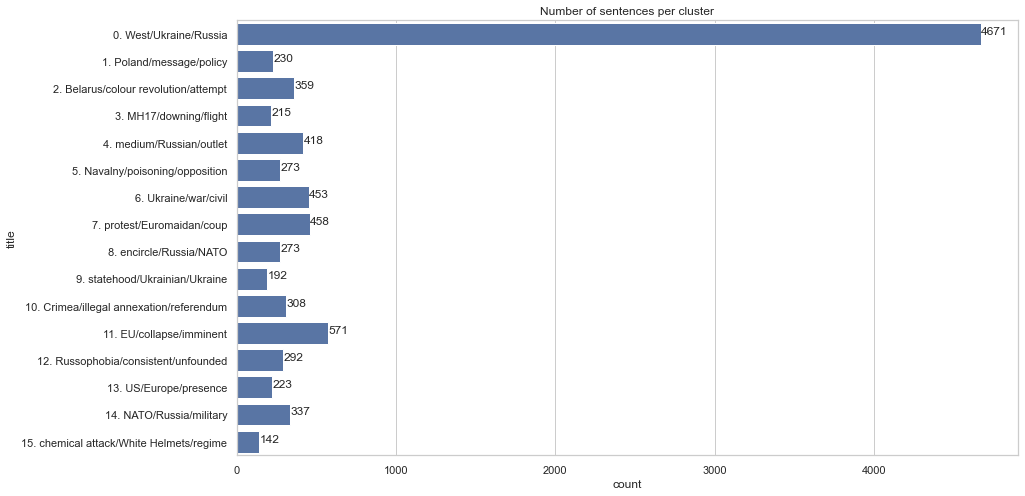

In [54]:
display_cluster_distribution(nar_cluster_list)

From the viewpoint of applications invoking a tokenizer it is a function that takes a sentences and returns a list of tokens.

In [55]:
mh17_c = None
nato_c = None
for c in nar_cluster_list:
    low_title = c.create_title().lower()
    if low_title.startswith('nato'):
        nato_c = c
    elif low_title.startswith('mh17'):
        mh17_c = c

        
table = f'<table><tr><td><b>{mh17_c.create_title()}</b></td><td><b>{nato_c.create_title()}</b></td><td>...........</td></tr>'
table += f'<tr><td>{"<br />".join(mh17_c.topterms)}</td><td>{"<br />".join(nato_c.topterms)}</td><td>...........</td></tr></table>'
display(HTML(table))

MH17/downing/flight,NATO/Russia/military,...........
MH17downingflighttrialJITdiscreditaimcrashcriminalresponsibilitydenyJoint Investigation TeammultipleinvestigationJoint International InvestigationRussiaInternational Joint Investigationundermineoverviewclick,NATORussiamilitaryagendaaggressiveexercisebelligerentenlargementthreatportraypeacebelligerenceUSUkraineclaimhostileAlliancepursueallegedlyorganisation,...........


<a id='summarization'></a>
# Summarizing narratives

The natural way to present a narrative is through stringing together words to form a story.

The outcome of our clustering process consists of a set of cluster centers, which are the "top terms" for each cluster, and a label for every sentence in the dataset indicating to what cluster it is assigned.

We already used the "top terms" to generate a title for each cluster. Now we will use the labelling of the dataset to generate a brief description of each cluster. 


## Generating text

We will generate a brief description for each narrative that we have found by generating a summary of the sentences for each cluster.

We will use [BART-large-CNN](https://huggingface.co/facebook/bart-large-cnn), which is a version of the autoregressive decoder BART fine-tuned for summarization on the CNN / DailyMail Dataset. This is an English-language dataset containing just over 300k unique news articles as written by journalists at CNN and the Daily Mail.

For a general introduction on generating text see Patrick von Platen's ["How to generate text: using different decoding methods for language generation with Transformers"](https://huggingface.co/blog/how-to-generate)

For generating text with Huggingface transformers there are a couple of parameters relevant to us here:
* `max_length` and `min_length`: these determine the size of the summary
* `no_repeat_ngram_size`: we saw earlier that phrases in our dataset are very repetitive (remember "recurrent pro-Kremlin disinformation narrative"?) We don't want our summary to be as repetitive as the dataset. We set this to 2 as we don't even want bigrams to be repeated in the summary.
* `repetition_penalty`: as above, we really don't want phrases to be repeated in our summary, so we set a high penalty on repetition.
* `do_sample` and `top_k`: to be set together if we want the algorithm to consider several results
* `num_beams`: number of paths to consider
* `num_return_sequences`: number of summaries to be returned. We will use this as we will evaluate them to pick the best.

## Pruning results

The generated summaries tend to favour a journalistic story over just presenting the most relevant information in terms of a few sentences. An example of this is that the generated summaries often contain quotes, as in "Mr. X said ...".

To mitigate this bias, we generate several summaries ("return sequences") and then select the one that has a [_cosine similarity_](https://www.machinelearningplus.com/nlp/cosine-similarity/) of its TF/IDF score closest to the sentences of the cluster as a whole.

In [56]:
torch_device = 'cpu'  # Practical choice: GPU has only 8GB memory, too little for a "large" model

import torch
import transformers
from transformers import BartTokenizer, BartForConditionalGeneration

num_beams = 6
length_penalty = 2.0
max_length = 100
min_length = 60
#temperature = 0.7
no_repeat_ngram_size = 2
repetition_penalty = 20.0
num_return_sequences = 5


def bart_summarize(text, 
                   num_beams=num_beams, 
                   length_penalty=length_penalty, 
                   max_length=max_length, 
                   min_length=min_length, 
                   #temperature=temperature,
                   no_repeat_ngram_size=no_repeat_ngram_size, 
                   num_return_sequences=num_return_sequences,
                   repetition_penalty=repetition_penalty 
                    ):
    # We re-initialize our model every time this summarisation method is called so the generated outcome will be the same.
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
    model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

    text = text.replace('\n', '')
    text_input_ids = tokenizer.batch_encode_plus([text], return_tensors='pt', max_length=1024)['input_ids'].to(
        torch_device)
    summary_ids = model.generate(text_input_ids, 
                                 num_beams=int(num_beams),
                                 do_sample=True,
                                 top_k=0,
                                 top_p=0.92,
                                 #temperature=temperature,
                                 early_stopping=True,
                                 length_penalty=float(length_penalty),
                                 max_length=int(max_length), 
                                 min_length=int(min_length),
                                 no_repeat_ngram_size=int(no_repeat_ngram_size),
                                 num_return_sequences=num_return_sequences,
                                 repetition_penalty=repetition_penalty)
    lst = []
    for t in summary_ids:
         lst.append(tokenizer.decode(t.squeeze(), skip_special_tokens=True))
    return lst


In [57]:
def summarize(cluster, nlp=nlp):
    rets = bart_summarize(' '.join(cluster.get_sentences()))
    lst = []
    for t in rets:
        t = t.replace(u'\xa0', u' ')
        if not t[-1] in ['.', '?', '!']:
            # Return sequences are not necessarily whole sentences. If the last sentence of the return sequences
            # doesn't end with a sentence ending interpunction, we remove it.
            doc = nlp(t)
            sentences = [s for s in doc.sents]
            lst.append(' '.join([s.text for s in sentences[:-1]]))
        else:
            lst.append(t)
    return lst

In [58]:
def create_tfidf_matrix(lst, tokenizer):
    """Convert list of documents to array of TF/IDF scores"""
    vectorizer = TfidfVectorizer(tokenizer=tokenizer, lowercase=False)
        
    vectors = vectorizer.fit_transform(lst)
    feature_names = vectorizer.get_feature_names_out()
    dense = vectors.todense()
    denselist = dense.tolist()
    return feature_names, denselist

In [59]:
import math

# See: https://www.machinelearningplus.com/nlp/cosine-similarity/
def cosine_similarity(tfidf1, tfidf2):
    """Calculate the cosine similarity between two tfidf dataframes with columns ['word','freq']"""
    assert isinstance(tfidf1, pd.DataFrame)
    assert isinstance(tfidf2, pd.DataFrame)
        
    df = pd.merge(tfidf1, tfidf2, on=["word"], how="outer")
    dotprod = (df['freq_x'] * df['freq_y']).sum()
    firstmod = math.sqrt((df['freq_x']**2).sum())
    secondmod = math.sqrt((df['freq_y']**2).sum())
    denominator = firstmod * secondmod
    
    if denominator == 0:
        return 0.0
    else:
        return dotprod / denominator

In [60]:
def get_best_summaries(cluster_list, tokenizer=my_tokenizer, nlp=nlp):
    """Generate summaries for each cluster."""
    summaries = []
    for cluster in cluster_list:
        lst = summarize(cluster, nlp=nlp)

        feat, mat = create_tfidf_matrix([' '.join(cluster.get_sentences())] + lst, tokenizer)
        cluster_df = pd.DataFrame({'word': list(feat), 'freq': mat[0]})
        sims = []
        for i, ret in enumerate(lst):
            ret_df = pd.DataFrame({'word': list(feat), 'freq': mat[i+1]})
            similarity = cosine_similarity(cluster_df, ret_df)
            sims.append(similarity)

        best_summary = lst[sims.index(max(sims))]
        summaries.append(best_summary)

    return summaries

In [61]:
def display_summaries(cluster_list, summaries):
    """Create a table displaying the summaries for all clusters."""
    html = '<table>\n'
    for i, cluster in enumerate(cluster_list):
        summary = summaries[i]
        html += f"<tr><td>{cluster.cluster_id}</td><td><h3>{cluster.create_title()}</h3></td></tr>\n"
        html += f"<tr><td>top terms</td><td>{', '.join(cluster.topterms)}</td></tr>\n"
        html += f"<tr><td>summary</td><td>{summary}</td></tr>\n"
    html += "</table>\n"
    display(HTML(html))

In [62]:
summaries = get_best_summaries(nar_cluster_list, tokenizer=my_tokenizer, nlp=nlp)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/cjr/miniconda3/envs/eudisinfo/lib/python3.7/site-packages/transformers/generation_utils.py:2343: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `trunca

In [63]:
display_summaries(nar_cluster_list, summaries)

0,West/Ukraine/Russia
top terms,"West, Ukraine, Russia, claim, US, Russian, coronavirus, country, consistent, value, conspiracy theory, example, state, aim, world, portray, case, Western, outlet, western"
summary,"The most common pro-Kremlin narratives have been linked to the pandemic. They range from bizarre conspiracy theories, to Ukraine responding inadequately with a false narrative of ‘Nazi Ukraine’ The stories are repeated by Sputnik Polska and disseminated through other sites according to their intended message. For example, they claim that liberals want to kill Christians - but this is just one of many faces of disinformation on women. You can't avoid extravagant narratives of Satan pulling"
1,Poland/message/policy
top terms,"Poland, message, policy, Kremlin, widespread, country, anti-Russian, Russophobic Poland, WWII, puppet-state, US, fully, foreign, Russophobic, historical, present, control, domestic, common, sovereignty"
summary,"This week we saw geopolitical disinformation narratives focus on the United States, Moldova and Poland. Pro-Kremlin outlets did push the well-known narrative about Poland as the American puppet. This message is a part of the Kremlin’s widespread crusade against anti-Russian,. Russophobic Poland which deliberately worsens its relations with Russia. EUvsDisinfo team debunks regularly this common pro-kremlin 'distraction' from Putin's policies."
2,Belarus/colour revolution/attempt
top terms,"Belarus, colour revolution, attempt, organise, western, disrupt, West, protest, relation, consistent, Belarusian-Russian, Western, country, instigate, message, portray, conspiracy, popular, effort, neighbourhood"
summary,This article promotes recurring pro-Kremlin disinformation narratives about the West's attempt to organise a colour revolution in Belarus and Russia.
3,MH17/downing/flight
top terms,"MH17, downing, flight, trial, JIT, discredit, aim, crash, criminal, responsibility, deny, Joint Investigation Team, multiple, investigation, Joint International Investigation, Russia, International Joint Investigation, undermine, overview, click"


## Findings on summaries

In most summaries there are one or a few reasonably good sentences that give insight in what the cluster is about. However, in most cases we find that there are also unhelpful sentences. Additionally, not all sentences are grammatically correct.

From the sentence construction we can see that the summarisation is aimed at single articles, e.g. "This article ..." or 

We can see this as a proof-of-concept or a baseline, but the result will have to be much better to be useful.

<a id='2d_projection'></a>
# Projecting clusters onto a 2D plan using word vectors and PCA

How do the "top terms" of the different clusters relate to each other? To say something about that we can use a vector representation of terms, use Principal Component Analysis to project the vectors to the 2D plane, and plot a diagram of the resulting points per cluster.

In [64]:
def get_similarities(cluster_tfidf_dict, cluster_tfidf_sentences, cluster_sentences):
    similarities = []
    res_df_lst = []
    for cluster_id in range(len(cluster_sentences)):
        lst = []
        for sentence_dict in cluster_tfidf_sentences[cluster_id]:
            if sentence_dict is None:
                lst.append(0.0)
            else:
                lst.append( cosine_similarity(cluster_tfidf_dict[cluster_id], sentence_dict) )
            
        similarities.append(lst)
        
        res_df_lst.append(pd.DataFrame({
                'sentence': cluster_sentences[cluster_id],
                'similarity': lst
                }))
    return res_df_lst

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import adjustText

In [66]:
def get_tfidf_for_all_clusters(cluster_list, tokenizer):
    feat, mat = create_tfidf_matrix([' '.join(c.get_sentences()) for c in cluster_list], tokenizer)
    clist = []
    for i, c in enumerate(cluster_list):
        v = mat[i]
        tfidf_dict = dict(zip(feat,v))
        c._cached_tfidf['dict'] = tfidf_dict
        clist.append(c)
    return clist

In [67]:
nar_cluster_list = get_tfidf_for_all_clusters(nar_cluster_list, my_tokenizer)

In [68]:
def create_wv_list(cluster_list, tokenizer):
    wv_list = []
    for cluster in cluster_list:
        d = cluster.get_tfidf(tokenizer)
        ctfidf_df = pd.DataFrame({
            'term': list(d.keys()),
            'score': list(d.values())
        }).sort_values(by='score', ascending=False)
        words = ctfidf_df.head(CENTROIDS)['term'].to_list()
        wv = []
        # Temporarily turn on meta-data and vectors so tokenizer returns tuple (word, meta-data)
        for w in words:
            parsed = tokenizer(w, with_meta=True, with_vectors=True)
            if len(parsed) != 1:
                print(f"Tokenization inconcistency: parsed len({len(parsed)}) for: ", w)
            
            else:
                meta = parsed[0][1]
                key = parsed[0][0]
                if key in d.keys():
                    t = (w, d[key], meta['vector'], meta['ent_type'], meta['pos'])
                    #t = (w, d[token.text], vector, ent_type, token.pos_)
                    wv.append(t)
                else:
                    print(f"key {key} is not in dictionary")
        wv_list.append(wv)

    return wv_list

In [69]:
from sklearn import preprocessing

def plot_2d_representation_of_terms(
    cluster_list,
    wv_list,
    clusters=None,
    label_x_axis = "x",
    label_y_axis = "y", 
    label_label = "word"):        
    
    pca = PCA(n_components = 2)
    
    palette = sns.color_palette("Paired")

    wv_flattened = []
    hues = []
    palette_counter = 0
    styles = []
    wordCounter = Counter()
    for cluster_id, wv_per_cluster_list in enumerate(wv_list):
        if clusters is None or cluster_id in clusters:
            # Only if we have a word vector we will represent the entry in the diagram
            only_with_vector = [wv for wv in wv_per_cluster_list if wv[2] is not None]
            wv_flattened.extend(only_with_vector)
            #hues.extend([palette_counter] * len(only_with_vector))
            hues.extend([cluster_id] * len(only_with_vector))
            palette_counter += 1
            
            for w in only_with_vector:
                styles.append(wordCounter[w[0]])
                wordCounter[w[0]] += 1

    word_plus_coordinates=[]
    for word, _, vec, _, _ in wv_flattened:
        current_row = []
        current_row.append(word)
        current_row.extend(vec)
        word_plus_coordinates.append(current_row)
    
    word_plus_coordinates = pd.DataFrame(word_plus_coordinates)
        
    coordinates_2d = pca.fit_transform(
        word_plus_coordinates.iloc[:,1:300])
    coordinates_2d = pd.DataFrame(
        coordinates_2d, columns=[label_x_axis, label_y_axis])
    coordinates_2d[label_label] = word_plus_coordinates.iloc[:,0]
        
    size_lst = []
    for x in wv_flattened:
        if x[1] == 0.0:
            print("error: 0.0 value for ", x[0])
            size_lst.append(0.1)
        else:
            try:
                size_lst.append(10+math.log(x[1]))
            except:
                print('error for ', x[0])
                size_lst.append(0.1)
    size_lst = np.array(size_lst).reshape(-1,1)
    scaler = preprocessing.MinMaxScaler()
    size_lst=scaler.fit_transform(size_lst)
    
    coordinates_2d['size'] = size_lst
    coordinates_2d['cluster'] = hues
    coordinates_2d['duplicates'] = styles
    
    # remove rows having a duplicate
    remove_indexes = []
    for i in range(len(styles)-1, 0, -1):
        duplicate = styles[i]
        if duplicate > 0:
            for j in range(0,i):
                if wv_flattened[j][0] == wv_flattened[i][0]:
                    remove_indexes.append(j)
    coordinates_2d = coordinates_2d.drop(remove_indexes)
    coordinates_2d = coordinates_2d.reset_index(drop=True)    
            
    plt.figure(figsize = (14,8))
    p1=sns.scatterplot(
        data=coordinates_2d, hue='cluster', legend='auto', sizes=(1,200), size='size', style='duplicates', 
        palette='tab10', x=label_x_axis, y=label_y_axis)
    
    title = 'Word clusters'
    if clusters is not None:
        title += ': '
        for cluster_id in clusters:
            c = cluster_list[cluster_id]
            title += f'{cluster_id}: {c.create_title()}; '
        title = title[:-2]
    p1.set_title(title)
    
    x = coordinates_2d[label_x_axis]
    y = coordinates_2d[label_y_axis]
    label = coordinates_2d[label_label]
    
    texts = [plt.text(x[i], y[i], label[i]) for i in range(len(x)-3)]
    adjustText.adjust_text(texts)

In [70]:
nar_wv_list = create_wv_list(nar_cluster_list, my_tokenizer)

key foreign-le is not in dictionary
Tokenization inconcistency: parsed len(2) for:  Defender-Europe 2020
Tokenization inconcistency: parsed len(3) for:  Syrian civil war


error: 0.0 value for  downing


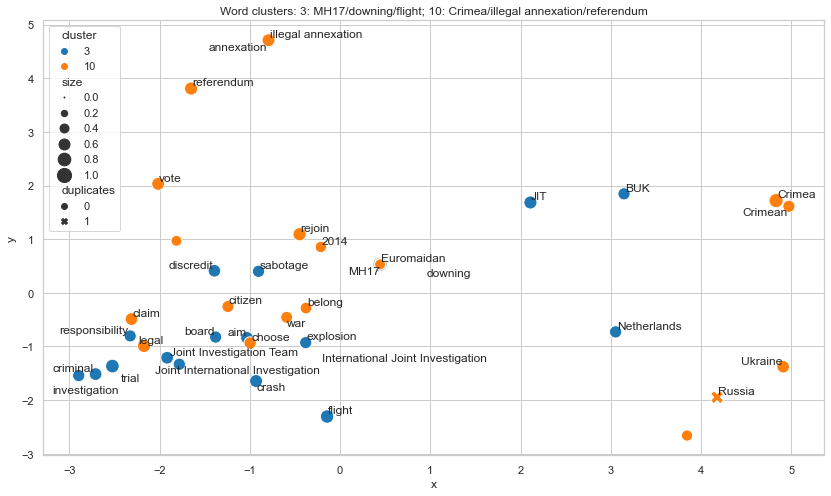

In [71]:
plot_2d_representation_of_terms(nar_cluster_list, nar_wv_list, clusters=[3,10])

### Interpreting the scatterplot

When we look at the representations for all clusters in the scatterplot above, we find:
* Absence of clear topographical clustering (not what you find in the success stories)
* Composite tokens are still separate, e.g. names like `George` and `Soros` or terms like `conspiracy theory`.
* We see a clear division of names on the right side and non-names on the left.

## Structuring out top list of terms for clusters

The division of names and non-names we see in the scatterplot suggests categorising terms as a further step in understanding clusters.

Before, we already used spaCy to tokenise our sentences. Now we will use spaCy's Name-Entity Recognition (NER) to categorise tokens. Tokens not categorised as entities, we divide into nouns, verbs, and adjectives. 

We will now divide the terms for each cluster in a number of categories:
* Geographical (GPE)
* Group (NORP)
* Organisation (ORG)
* Person (PERSON)
* Noun
* Verb
* Adjective





In [72]:
def cluster_wv_to_list(wv):
    def legitimate_ent(t):
        return t[2] in ['GPE', 'NORP', 'ORG', 'PERSON']
    def is_geographical(t):
        return t[2] == 'GPE'
    
    def is_group(t):
        return t[2] == 'NORP'
        
    def is_organisation(t):
        return t[2] == 'ORG'
    
    def is_person(t):
        return t[2] == 'PERSON'
    
    def is_noun(t):
        return not legitimate_ent(t) and t[3] in ['NOUN', 'PROPN', 'NUM', 'DATE']
    
    def is_verb(t):
        return not legitimate_ent(t) and t[3] in ['VERB']
    
    def is_adjective(t):
        return not legimate_ent(t) and t[3] in ['ADJ']

    def is_other(t):
        """Anything we haven't categorised yet"""
        return not legitimate_ent(t) and not is_noun(t) and not is_verb(t) and not is_adjective(t)

    def pp(t):
        mul = int(t[1]*10)
        print('*'*mul, t[0], '*'*mul)

In [73]:
class TypeChecker(object):
    def __init__(self):
        self.counter = Counter()
        self.colors = ['brown', 'magenta', 'orange', 'blue', 'green', 'red']
        self.colormap = {}
    def add(self, t):
        self.counter[t[0]] += 1
    def _init_colors(self):
        """Map tokens to colors according to descending frequency"""
        for k, v in self.counter.most_common():
            if v < 2:
                break
            self.colormap[k] = self.colors.pop()
            if not self.colors:
                break
    def legitimate_ent(self, t):
        return t[3] in ['GPE', 'NORP', 'ORG', 'PERSON']
    def is_geographical(self, t):
        return t[3] == 'GPE'
    
    def is_group(self, t):
        return t[3] == 'NORP'
        
    def is_organisation(self, t):
        return t[3] == 'ORG'
    
    def is_person(self, t):
        return t[3] == 'PERSON'
    
    def is_noun(self, t):
        return not self.legitimate_ent(t) and t[4] in ['NOUN', 'PROPN', 'NUM', 'DATE']
    
    def is_verb(self, t):
        return not self.legitimate_ent(t) and t[4] in ['VERB']
    
    def is_adjective(self, t):
        return not self.legitimate_ent(t) and t[4] in ['ADJ', 'ADV']
    
    def is_other(self, t):
        return not self.legitimate_ent(t) and not self.is_verb(t) and not self.is_adjective(t) \
            and not self.is_noun(t)
    
    def pp(self, t):
        """Print the term. Use weight for higher prevalence within cluster, use color to mark
        a term that also occurs in other clusters (same color in all clusters)."""
        if len(self.colormap) == 0:
            self._init_colors()
        mul = int(t[1]*10)
        s = f'<span style="font-size: {1+0.2*(mul)}em;'
        if mul > 2:
            s += 'font-weight: bold;'
        if t[0] in self.colormap.keys():
            color = self.colormap[t[0]]
            s += f'color: {color};'
        s += f'">{t[0]}</span>'
        return s


In [74]:
def cluster_wv_to_table(wv, ts=None):
    if ts is None:
        ts = TypeChecker()

    geographical = []
    group = []
    organisation = []
    person = []
    noun = []
    verb = []
    adjective = []
        
    for t in wv:
        ts.add(t)
        if ts.is_geographical(t):
            geographical.append(t)
        if ts.is_group(t):
            group.append(t)
        if ts.is_organisation(t):
            organisation.append(t)
        if ts.is_person(t):
            person.append(t)
        if ts.is_noun(t):
            noun.append(t)
        if ts.is_verb(t):
            verb.append(t)
        if ts.is_adjective(t):
            adjective.append(t)
        if ts.is_other(t):
            print(f"Failed to categorise: {t[0]} - {t[4]}")
            
    #for l in [geographical, group, organisation, person, noun, verb, adjective]:
    #    s += '<td>' + ',<br />'.join([ts.pp(x) for x in l]) + '</td>'

    return ts, (geographical, group, organisation, person, noun, verb, adjective)

In [75]:
from IPython.display import HTML

def display_wv_list(wv_list, cluster_list):
    header = '<table><tr><th>cluster</th><th>Geographical</th><th>Group</th><th>Organisation</th>'\
+'<th>Person</th><th>Noun</th><th>Verb</th><th>Adjective</th></tr>'
    s = header
    ts = TypeChecker()
    col_list = []
    for cluster in cluster_list:
        cluster_id = cluster.cluster_id
        ts, cols = cluster_wv_to_table(wv_list[cluster_id], ts)
        col_list.append((cluster_id, cols))

    for cluster_id, cols in col_list:
        n_sentences = len(cluster_list[cluster_id].get_sentences())
        s += f'<tr><td>cluster {cluster_id}<br />{cluster_list[cluster_id].create_title()}<br />({n_sentences})</td>'
        for l in cols:
            s += '<td>' + ',<br />'.join([ts.pp(x) for x in l]) + '</td>'
        s +=  '</tr>'
    s += '</table>'
    display(HTML(s))
    return ts

In [76]:
dis_ts = display_wv_list(nar_wv_list, nar_cluster_list)

cluster,Geographical,Group,Organisation,Person,Noun,Verb,Adjective
cluster 0West/Ukraine/Russia(4671),"Russia,US,Ukraine","West,Russian",,,"country,value,state,coronavirus,world,vaccine,government,society,conspiracy theory","claim,aim","consistent,traditional,Western,global"
cluster 1Poland/message/policy(230),"Poland,US",American,Kremlin,,"country,message,policy,WWII,puppet-state,anti-Russian,banana,present,republic",control,"widespread,fully,foreign,domestic,historical,Russophobic"
cluster 2Belarus/colour revolution/attempt(359),"Belarus,Russia,Poland",West,Belarusian-Russian,,"colour revolution,relation,country","organise,attempt,disrupt,protest,effort,portray,instigate","western,consistent,Western,popular"
cluster 3MH17/downing/flight(215),"Netherlands,Russia",,"JIT,Joint Investigation Team,Joint International Investigation,BUK,International Joint Investigation",,"MH17,trial,flight,crash,investigation,sabotage,explosion,board,responsibility","downing,aim,discredit",criminal
cluster 4medium/Russian/outlet(418),"Russia,Ukraine,US","Russian,West","RT,Kremlin",,"outlet,government,freedom,vaccine,state,elite","claim,spread","medium,mainstream,social,Western,state-controlled"
cluster 5Navalny/poisoning/opposition(273),Russia,"Russian,West",,"Navalny,Skripal,Litvinenko","opposition,figure,caffeine,blood,alcohol,activist,block,sanction","poisoning,hope,die,excuse,find",prominent
cluster 6Ukraine/war/civil(453),"Ukraine,Donbas,Russia,Minsk,US","Nazi,Russian","eastern,Euromaidan",,"war,conflict,agreement,state,election","control,claim,portray,allege","civil,external"
cluster 7protest/Euromaidan/coup(458),"Ukraine,US,Kyiv",West,Euromaidan,,"coup,colour revolution,fund,14,state,2013-14,justice,2013,d’état","protest,claim,orchestrate,paint","popular,racial"
cluster 8encircle/Russia/NATO(273),"Russia,US",West,NATO,,"agenda,sanction,military","encircle,claim,attempt,exercise,weaken,isolate,threaten","belligerent,Western,ultimate,hostile,western"
cluster 9statehood/Ukrainian/Ukraine(192),"Ukraine,US","Ukrainian,West",,,"statehood,challenge,history,independence,design,sovereignty,state,election,country,Pro-Kremlin","undermine,claim,denigrate,abandon,fail",consistent


Let's look at the number of occurences of terms that are present in more than one cluster:

Observations:
1. The word `claim` is present in most clusters.
2. Looking further, we see `portray` and `allege`, which have related meanings.
3. Geographical terms are dominant: Russia, Ukraine, US, West, and EU.
4. Remarkably, `US` occurs twice as often as `EU`. We are dealing with a small sample here, but shouldn't we see that EUvsDisinfo talks more about the EU than the US? As a further step we could pursue if the EU plays a second fiddle in its own strategic communications compared to the US.

## Analysing the results

1. The clusters we got give a reasonable approximation of the talking points of EU strategic communications with regard to policy on Ukraine. (FIXME: can I find an overview of such talking points?)
2. This confirms the analysis of `disinformation` as being about `narratives`.
3. The most important terms are regional or identifying ethnic groups.
4. Closely related to `disinformation` are `claim`, `allege`, and `portray`.
5. Just looking at these terms, we see a primary focus on US versus Russia with a focus on Ukraine.

<a id='cluster_similarities'></a>
## Cluster similarities

Some clusters may be more similar to each other than others. Let's quantify this using their TF-IDF similarities and place the result in a heat map.



In [77]:
def create_cluster_distance_matrix(cluster_list, tokenizer=my_tokenizer, nlp=nlp):
    """Generate summaries for each cluster."""
    matrix = []
    lst = [' '.join(c.get_sentences()) for c in cluster_list]
    feat, mat = create_tfidf_matrix(lst, tokenizer)
    tfidf_lst = []
    for i in range(len(lst)):
        tfidf_lst.append(pd.DataFrame({'word': list(feat), 'freq': mat[i]}))

    for tfidf1 in tfidf_lst:
        row = []
        for tfidf2 in tfidf_lst:
            sim = cosine_similarity(tfidf1, tfidf2)
            row.append(sim)
        matrix.append(row)
    return matrix

In [78]:
matrix = create_cluster_distance_matrix(nar_cluster_list, tokenizer=my_tokenizer)

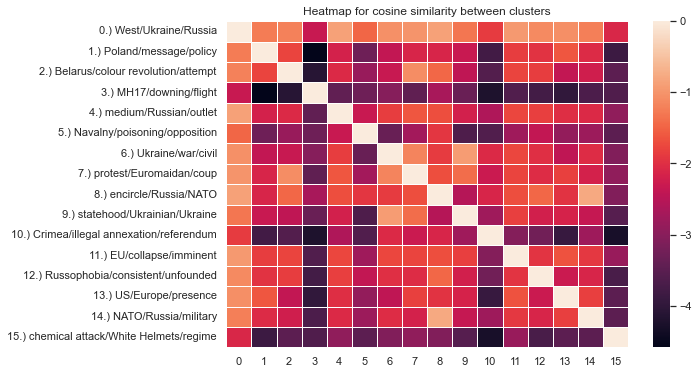

In [79]:
name_list = [f'{i}.) {c.create_title()}' for i, c in enumerate(nar_cluster_list)]

fig, ax = plt.subplots(figsize=(9, 6))
# In cosine similarity can result in values between -1 and 1, but in practice they are close to 0.
# We take the log of the values to extend the difference.
hm = sns.heatmap(np.log(np.array(matrix)),  linewidths=.5, ax=ax, yticklabels=name_list)
hm.set_title('Heatmap for cosine similarity between clusters')
plt.show()

In the heatmap, lighter is more similar, darker is less similar. 

## Interpretation

In the heatmap, lighter is more similar, darker is less similar.

What we see in the heatmap is:
* Obviously, all clusters are most similar to themselves (the light diagonal)
* Cluster _Russian /Ukraine / medium_ (the one consisting of the most sentences) is relatively similar to all other clusters
* Cluster _MH17 / downing / flight_ is least similar to all others (black and purple blocks)

So, let's see some sentences from these two clusters.

In [80]:
cluster_id = 0
c = nar_cluster_list[cluster_id]
print(c.create_title())
c.get_random_sentences(10)

West/Ukraine/Russia


["The story advances a recurring pro-Kremlin narrative of war crimes perpetrated in Syria by the US and its allies, and provides no evidence of any civilian deaths resulting from the coalition's offensive on Baghouz.",
 'Recurrent pro-Kremlin disinformation narrative, questioning the legitimacy of democracy and Western institutions and, in this case, favouring Donald Trump.',
 'The claim advanced recurring pro-Kremlin disinformation narratives that certain Western organisations exercise an enormous amount of secret influence on global affairs.',
 'The plot echoes a narrative central to pro-Kremlin disinformation: that foreign influences can and will drive Russia towards moral decline, unless a strong Russian government defends the country against these contacts.',
 'The narrative also represents the conflict in Nagorno-Karabakh.',
 'This narrative aims to question the legitimacy of Western democratic institutions.',
 'This is a recurring pro-Kremlin disinformation narrative about the N

In [81]:
cluster_id = 3
c = nar_cluster_list[cluster_id]
print(c.create_title())
c.get_random_sentences(10)

MH17/downing/flight


['Recurring pro-Kremlin disinformation narrative about the MH17 crash.',
 'One of the many recurring, and occasionally conflicting, disinformation narratives around the downing of flight MH17 which appear again due to the imminent trial of the suspects (see below).',
 'Recurring pro-Kremlin disinformation narrative about the MH17, an attempt to discredit the Joint International Investigation and a criminal trial that has started in the Hague.',
 'Recurrent pro-Kremlin disinformation narrative on the downing of flight MH17 over Ukraine, aiming to discredit the criminal trial and the Joint Investigation Team (JIT).',
 'Recurring pro-Kremlin disinformation narrative about the downing of the flight MH17.',
 'Recurring pro-Kremlin disinformation narrative about the MH17, aiming to undermine the Joint International Investigation of the crash and subsequent criminal trial.',
 'This is a recurring disinformation narrative from pro-Kremlin outlets blaming Ukrainian troops for shooting down Mala

In [82]:
def display_cluster_similarity_scores(cluster_list, matrix):
    """Display horizontal barchart showing number of sentences per cluster"""
    titles = []
    sum_of_similarities = []
    for i, row in enumerate(matrix):
        titles.append(f'{i}. {nar_cluster_list[i].create_title()}')
        sum_of_similarities.append(sum(row))
    sum_score_df = pd.DataFrame({'title': titles, 'sum of similarities': sum_of_similarities})
    sum_score_df = sum_score_df.sort_values(by='sum of similarities', ascending=False)
    
    plt.figure(figsize=(14,8))
    title = 'Cumulative similarity per cluster'
    plt.title(title)
    ax = sns.barplot(data=sum_score_df, y='title', x='sum of similarities', orient='h', color=sns.color_palette()[0])

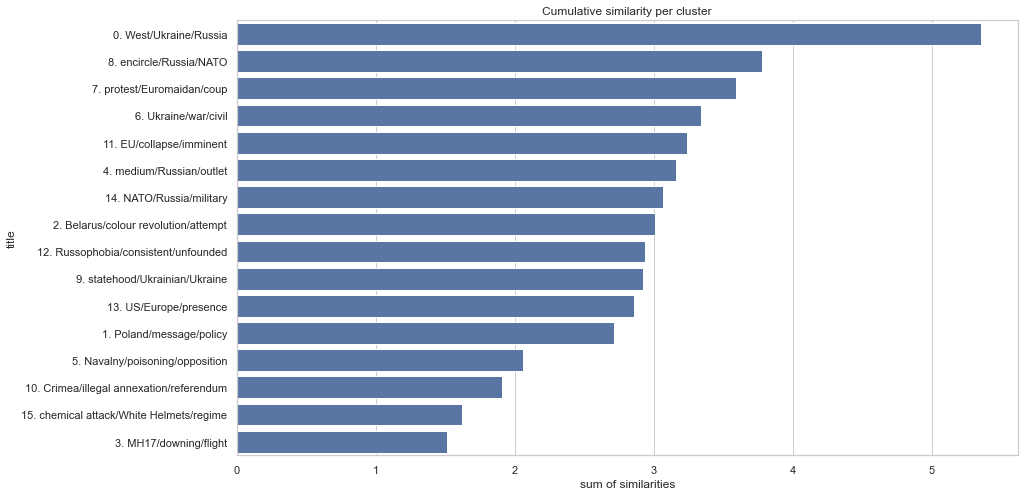

In [83]:
display_cluster_similarity_scores(nar_cluster_list, matrix)

### Findings

* The cluster titled `West/Ukraine/Russia` is most similar to the other clusters.
* The clusters `MH17/downing/flight`, `chemical attack/White Helmets/regime`, `Crimea/illegal annexation/referendum`, and `Navalny/poisoning/opposition` are the least similar

This makes sense when we think of the content of these clusters: The `West/Ukraine/Russia` fits the general domain of the dataset, whereas the last four clusters have very specific vocabularies not shared with other clusters.

In [84]:
def display_wv_list_with_summary(wv_list, cluster_list, summaries=None):
    header = '<table><tr><th>Geographical</th><th>Group</th><th>Organisation</th>'\
+'<th>Person</th><th>Noun</th><th>Verb</th><th>Adjective</th></tr>'
    s = header
    ts = TypeChecker()
    col_list = []
    tot_sentences = 0
    for cluster in cluster_list:
        cluster_id = cluster.cluster_id
        ts, cols = cluster_wv_to_table(wv_list[cluster_id], ts)
        num_sentences = len(cluster.get_sentences())
        tot_sentences += num_sentences
        col_list.append((cluster_id, cols, num_sentences))
        

    for cluster_id, cols, num_sentences in col_list:
        if summaries:
            summary = summaries[cluster_id]
        sent_percent = int((num_sentences / tot_sentences)*100)
        s += f'<tr><td colspan="4" align="left"><h3>cluster {cluster_id}: {cluster_list[cluster_id].create_title()} ** ({num_sentences} sentences, {sent_percent}%)</h3></td><td colspan="3"></td></tr>'
        s += '<tr>'
        for l in cols:
            s += '<td>' + ',<br />'.join([ts.pp(x) for x in l]) + '</td>'
        s +=  '</tr>'
        if summaries:
            s += f'<tr><td></td><td colspan="6">{summary}</td></tr>'
    s += '</table>'
    display(HTML(s))
    return ts

In [85]:
#ts = display_wv_list_with_summary(nar_wv_list, nar_cluster_list, summaries)
ts = display_wv_list_with_summary(nar_wv_list, nar_cluster_list)

<a id="wherefromhere"></a>
# Where from here?

The goal of the present investigation was to explore how the notion of disinformation is used in a specific dataset. What we found is first a connection with `narratives` ad second the indication that there are a number of such narratives that are "recurrent", that is, they are invoked repeatedly.

We can go in three directions from here:
* New research directions
* Improve on the present results; better exploration
* Explore conceptual consequences


## New research directions

### Extract more data

From the original body of articles we extracted only the sentences with the word `disinformation` or `narrative` in them.

For constructing narratives, we have only the data from sentences with the word narrative in them. From the context of these sentences we can extract more data relevant to build up the structure of narratives. The hard part there is obviously how to determine what is "context" and what is not.

### Apply research in narrative theory

Combine theory on information retrieval with the structure of narratives to create better descriptions of the different recurrent narratives.

### Explore conceptual consequences

What is the relation between disinformation and narrative? E.g. anything verifiably false is an individual statement, not some entire "narrative". Also, it is understandable that "Doctors advise: drink chloride to prevent Covid" is not merely false and misleading, and can lead to harm. But how can  


## Improve on the present results; better exploration

Examples:
* Fine-tune the structural elements used in representating clusters
* Find a better summarization system 





<a id='conclusion'></a>
# Conclusion

Starting out on a exploration into the actual usage of the word `disinformation`, we found that:
* `disinformation` is primarily used as a qualifier of the notion of a `narrative`.
* A significant number of occurrences are formulaic, like a mantra: `pro-Kremlin disinformation narrative`.

From this we changed the direction of our exploration to the occurrences of `narrative` in the same body of text. Most of the sentences in the original body of text with the word `narrative` also contain the word `disinformation`.

Most importantly, looking at definitions of `disinformation` and of `narrative`, we find that our statistical investigation warrants us to narrow down what disinformation is about. From the original definition of disinformation being on "false or misleading information" we got to "false or misleading narratives". Where "information" can be about anything, narratives are typically about people, places, and actions.

Combining this with another finding, that these narratives are "recurrent", we moved to explore the question _"What narratives can we distinguish in our dataset?"_
Using prevalence of terms in sentences we clustered them, arbitrarily in twelve clusters. We found one cluster to contain about half the dataset and the rest of the same order of size.

With a background of domain knowledge, the prevalent terms per cluster make sense. They make even better sense when giving them a structured presentation in terms of persons, locations, and part-of-sentence types that help us see them as part of narratives.

A second presentation of clusters was created by taking all sentences of a cluster and summarizing them using a pre-trained language model. This led to some reasonable outcomes and some that made little sense.


